
<h1><center>Data Analytics</h1>
<h2><center>Homework 7</h2>
<h3><center>Name: 李權桓   &emsp;   ID:10546004</h3>

# Q1

In [48]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
from scipy import stats
import os
import re
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
%matplotlib inline


### loading ORL faces data

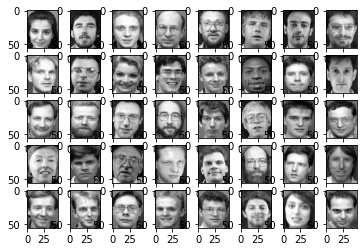

In [64]:
# get current working directory
cwd= os.getcwd()

# add the read directory to the path
rd = os.path.join(cwd)
zip_file = ZipFile('ORL Faces.zip')
dfs = {png_file.filename: image.imread(zip_file.open(png_file.filename))
       for png_file in zip_file.infolist()
       if png_file.filename.endswith('.png')}
png_df = pd.DataFrame([dfs])

# define gender by hand, each value for 10 pictures
col_name = list(png_df.columns)
fig, ax = plt.subplots(5, 8)
genders = [0,1,1,1,1,1,1,1,
           1,1,0,1,1,1,1,1,
           1,1,1,1,1,1,1,1,
           0,1,1,1,1,1,1,1,
           1,1,1,1,1,1,0,1]
dic = {}          
k = 0
# insert all gender to new row
for i in col_name:    
    match = re.search(r'\w*\s*\w*\/\d*\_1.png',i) 
    if match:
        #print(match.group(), k)
        plt.subplot(5,8,k+1)
        plt.imshow(png_df[i][0],cmap='gray')
        k = k +1
    dic[i]=[genders[k-1]]

In [5]:
# flatten all pics data 
df2 = pd.concat([png_df,pd.DataFrame(dic)]).reset_index(drop=True)
sample_df = df2.rename(index={0:'data',1:'gender'}).T
data_mat = np.array(np.ndarray.flatten(sample_df['data'][0]))
for i in range(1, len(sample_df)):
    data_mat = np.concatenate((data_mat,
         np.array(np.ndarray.flatten(sample_df['data'][i]))))
data_mat = data_mat.reshape(400,2576)
data_mat.shape

(400, 2576)

### Logistic Regression results

In [40]:
# using sklearn package
sample_df = df2.rename(index={0:'data',1:'gender'}).T
X = data_mat
y = sample_df['gender'].to_numpy()
y = y.astype(np.int64)


X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.2,random_state=1)
LR = LogisticRegression().fit(X_train,y_train)
score = LR.score(X_test,y_test)
print('Accuracy: ', score)


Accuracy:  0.95625


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 𝑘-Nearest Neighbors results

In [47]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print('Accuracy: ' , neigh.score(X_test,y_test))


Accuracy:  0.959375


### Support vector machine results

In [50]:
svm_model = svm.SVC(kernel='poly').fit(X_train, y_train)
print('Accuracy: ' , svm_model.score(X_test,y_test))


Accuracy:  0.971875


## Q1 discussion

The SVM result is more promising than the others because I set my kernel is `poly`.
It's not necessary means the setting is for every dataset.
This is only we can have confidence say this is better setting in this dataset.

# Q2

In [79]:
# define main PCA function

def myPCA(m , isCorrMx = False ) :
    m_bar = np.mean(m.T,axis=1)
    # print([float(i) for i in m_bar])
    Center_mat = m - [float(i) for i in m_bar]
    # print(Center_mat)

    if isCorrMx:
        V = np.corrcoef(m.T)
    else:
        V = np.cov(m.T)
    eig_value, eig_vector = np.linalg.eig(V)
    result = eig_vector.T.dot(Center_mat.T).T
    # print('Eigen value :',eig_value)
    # print('Eigen vector :',eig_vector)
    # print('PCA results :', result )
    return result , eig_value , eig_vector

In [80]:
# do data transpose
m = data_mat.T
m.shape

result , eig_value , eig_vector = myPCA(m, isCorrMx = False)
total_Var = sum(eig_value)
print('The total variance is ', total_Var)
cum_Var = []
tmp = 0
for i in eig_value:
    tmp +=i
    cum_Var.append(tmp)
np.where(cum_Var/total_Var>.5)[0][0]
for i in range(5,10):
    index = np.where(cum_Var/total_Var>i/10)[0][0] # return 1st index 
    output = cum_Var[index]
    print('The PC',index+1,': the cumulative variance is ', round(output, 2 ),'. The percentage is ', round(output/total_Var*100,1),'%')

The total variance is  13.594727653440655
The PC 2 : the cumulative variance is  7.74 . The percentage is  57.0 %
The PC 3 : the cumulative variance is  8.36 . The percentage is  61.5 %
The PC 6 : the cumulative variance is  9.59 . The percentage is  70.5 %
The PC 15 : the cumulative variance is  10.91 . The percentage is  80.2 %
The PC 47 : the cumulative variance is  12.25 . The percentage is  90.1 %


The The PC 15 is above 80% variance.

In [81]:
# from the previouse results , PC9 is good enought

m_bar = np.mean(m.T,axis=1)
Center_mat = m - [float(i) for i in m_bar]

# extract 90% variance eigenvector. Choice first r component
r = 15
update_eig_vector = np.zeros_like(eig_vector)
update_eig_vector[:,:r] = eig_vector[:,:r]

# PCA reverse transformation with r
pic_PCA = m.dot(update_eig_vector.T)+ Center_mat 

### Logistic Regression results after PCA

In [82]:
# using sklearn package

X = pic_PCA.T
y = sample_df['gender'].to_numpy()
y = y.astype(np.int64)


X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.2,random_state=1)
LR = LogisticRegression().fit(X_train,y_train)
score = LR.score(X_test,y_test)
print('Accuracy: ', score)


Accuracy:  0.94375


### 𝑘-Nearest Neighbors results after PCA

In [56]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print('Accuracy: ' , neigh.score(X_test,y_test))


Accuracy:  0.934375


### Support vector machine results after PCA

In [57]:
svm_model = svm.SVC(kernel='poly').fit(X_train, y_train)
print('Accuracy: ' , svm_model.score(X_test,y_test))


Accuracy:  0.94375


/usr/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


The significant pixels are ( 0 , 34 )
The significant pixels are ( 0 , 35 )
The significant pixels are ( 3 , 23 )
The significant pixels are ( 4 , 16 )
The significant pixels are ( 4 , 18 )
The significant pixels are ( 12 , 2 )
The significant pixels are ( 14 , 1 )
The significant pixels are ( 17 , 45 )
The significant pixels are ( 22 , 41 )
The significant pixels are ( 23 , 4 )
The significant pixels are ( 25 , 40 )
The significant pixels are ( 26 , 26 )
The significant pixels are ( 27 , 25 )
The significant pixels are ( 27 , 27 )
The significant pixels are ( 29 , 20 )
The significant pixels are ( 30 , 5 )
The significant pixels are ( 31 , 1 )
The significant pixels are ( 31 , 2 )
The significant pixels are ( 31 , 5 )
The significant pixels are ( 31 , 6 )
The significant pixels are ( 31 , 17 )
The significant pixels are ( 31 , 35 )
The significant pixels are ( 31 , 43 )
The significant pixels are ( 32 , 1 )
The significant pixels are ( 32 , 7 )
The significant pixels are ( 32 , 35 )
T

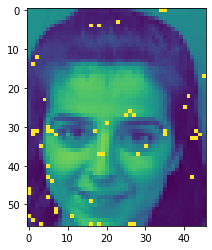

In [72]:
from sklearn.linear_model import Lasso
# use the min MSE
lasso_test = Lasso(alpha=.001,normalize=True)

lasso_test.fit(data_mat, sample_df['gender'])
lasso_test.coef_
pixels = np.where(lasso_test.coef_ != 0)
plot_df = png_df.copy()
pixels_index = []
for i in pixels[0]:
    row = int(np.floor(i/np.matrix(sample_df['data'][0]).shape[1]) )
    col = i - row*np.matrix(sample_df['data'][0]).shape[1]
    print('The significant pixels are (',row, ',',col, ')')
    plot_df['ORL Faces/10_1.png'][0][row][col]=1
    pixels_index.append([row, col])

plt.imshow(plot_df['ORL Faces/10_1.png'][0])


### Logistic Regression results after LASSO

In [96]:
# using sklearn package
X  = np.zeros((400, 2576))
for i in range(data_mat.shape[0]):
    X[i][pixels] = data_mat[i][pixels]

y = sample_df['gender'].to_numpy()
y = y.astype(np.int64)


X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.2,random_state=1)
LR = LogisticRegression().fit(X_train,y_train)
score = LR.score(X_test,y_test)
print('Accuracy: ', score)


Accuracy:  0.946875


### 𝑘-Nearest Neighbors results after LASSO

In [97]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print('Accuracy: ' , neigh.score(X_test,y_test))


Accuracy:  0.95625


### Support vector machine results after LASSO

In [98]:
svm_model = svm.SVC(kernel='poly').fit(X_train, y_train)
print('Accuracy: ' , svm_model.score(X_test,y_test))


Accuracy:  0.95


The accuracy when using LASSO is better than PCA with q=15. However, my results don't show signifigent improving.

# Q3

In [99]:
# Read Text Files with Pandas

col_names = ['mpg','cylinders','displacement','horsepower',
            'weight','acceleration','year','origin','car_name']
# read text file into pandas DataFrame
df = pd.read_fwf("auto-mpg.data.txt",header=None,names = col_names)
# df = pd.DataFrame(df1.to_numpy() , columns=col_names)
# display DataFrame
df = df[~df.isin({'?'}).any(1)]
print(df)


      mpg  cylinders  displacement horsepower  weight  acceleration  year  \
0    18.0          8         307.0      130.0  3504.0          12.0    70   
1    15.0          8         350.0      165.0  3693.0          11.5    70   
2    18.0          8         318.0      150.0  3436.0          11.0    70   
3    16.0          8         304.0      150.0  3433.0          12.0    70   
4    17.0          8         302.0      140.0  3449.0          10.5    70   
..    ...        ...           ...        ...     ...           ...   ...   
393  27.0          4         140.0      86.00  2790.0          15.6    82   
394  44.0          4          97.0      52.00  2130.0          24.6    82   
395  32.0          4         135.0      84.00  2295.0          11.6    82   
396  28.0          4         120.0      79.00  2625.0          18.6    82   
397  31.0          4         119.0      82.00  2720.0          19.4    82   

     origin                     car_name  
0         1  "chevrolet chevelle

### Logistic Regression results

In [100]:
#define predictor and response variables
m = df.loc[:,['mpg','cylinders','displacement','horsepower',
            'weight','acceleration', 'year']].astype(float).to_numpy()
X = m
y = df.loc[:,['origin'] ]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.2,random_state=1)
LR = LogisticRegression().fit(X_train,y_train)
score = LR.score(X_test,y_test)
print('Accuracy: ', score)

Accuracy:  0.7643312101910829


/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 𝑘-Nearest Neighbors results

In [101]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print('Accuracy: ' , neigh.score(X_test,y_test))


Accuracy:  0.6146496815286624


/usr/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Support vector machine results

In [102]:
svm_model = svm.SVC(kernel='poly').fit(X_train, y_train)
print('Accuracy: ' , svm_model.score(X_test,y_test))


Accuracy:  0.6878980891719745


/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In AutoMPG data, the accuracy does not good compare to ORL face data.
Because we found `cylinders`,`displacement`,`horsepower` and `weight` are correlated factors, this will impact on model classification rate.